In [1]:
# KBO Data Analyst Technical Prompt 
# Objective: Using the provided csv file, create a model that predicts miss probability.
# Name: Jameel Kaba

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn import metrics
import lightgbm as lgb

In [2]:
# Loading the pitching data from csv
data0 = pd.read_csv("Insert kbo_pitching.csv here")

In [3]:
# Shape of initial data
data0.shape

(30000, 21)

In [4]:
# Six possible outcomes from a pitch, but only three result in the bat being swung
data0['pitch_result'].unique()

array(['StrikeSwinging', 'BallCalled', 'StrikeCalled', 'InPlay',
       'FoulBall', 'HitByPitch'], dtype=object)

In [5]:
# Removing plays in which the batter did not swing
# Called Balls, Strikes, and Hit by pitch because the batter does not swing
data1 = data0.loc[(data0['pitch_result']!='BallCalled') & (data0['pitch_result']!='StrikeCalled') 
                  & (data0['pitch_result'] != 'HitByPitch')]

In [6]:
# Shape of data after removing non swing plays
data1.shape

(13293, 21)

In [7]:
# Check to see if there are any blanks/na in the data
# In the event that there are blanks/na in the data further steps would be added here to filter the data
data1.isna().sum()

pitch_uid             0
strikes               0
balls                 0
outs                  0
pitcher_throws        0
batter_side           0
pitch_result          0
rel_speed             0
extension             0
horz_appr_angle       0
horz_break            0
horz_rel_angle        0
induced_vert_break    0
plate_loc_height      0
plate_loc_side        0
rel_height            0
rel_side              0
spin_axis             0
spin_rate             0
vert_appr_angle       0
vert_rel_angle        0
dtype: int64

In [8]:
pd.set_option('display.max_columns', None)

In [9]:
# Indicating whether or not the batter swung and miss (1 indicates swing and miss, 0 indicates any other result)
data1['miss'] = False

<ipython-input-9-f655bd794dd0>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data1['miss'] = False


In [10]:
# There are 3 possible outcomes in which the batter swings
data1['pitch_result'].unique()

array(['StrikeSwinging', 'InPlay', 'FoulBall'], dtype=object)

In [11]:
# Setting the miss column equal to 1 on all pitches the batter swung and miss
data1.loc[data1['pitch_result'].isin(['StrikeSwinging']), 'miss'] = True

/Users/Jameel/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)


In [12]:
# Getting the columns we need for our model
relevant_df = data1[['plate_loc_side', 'plate_loc_height', 'rel_speed', 'horz_break',
                    'induced_vert_break', 'pitcher_throws', 'strikes', 'balls', 'miss']]

In [13]:
# Taking a peek at the data
relevant_df.head()

,plate_loc_side,plate_loc_height,rel_speed,horz_break,induced_vert_break,pitcher_throws,strikes,balls,miss
0,0.150202,0.953636,143.681352,-10.603149,38.745681,L,1,0,True
4,-0.335328,0.871335,148.493087,39.376429,44.760313,R,1,2,False
7,-0.057734,0.720358,141.531554,-26.296146,45.148358,L,2,3,False
9,0.065422,0.874030,151.739071,26.520986,50.356785,R,2,2,False
10,0.191811,0.884483,142.811447,34.192951,54.149398,R,0,1,False


In [14]:
# One-hot encoding the categorical feature
hot_df = pd.get_dummies(relevant_df, prefix = ['pitcher_throws',])

In [15]:
# Separating our dependent variable
y = hot_df['miss']
y = y.astype(str)

In [16]:
# Getting our independent variable
x = hot_df.drop('miss', axis = 1).values

In [17]:
# Splitting the test and training data
X_train, X_test, y_train, y_test = train_test_split(x,y,test_size = 0.2, random_state = 0)

In [18]:
# Initializing model
clf = lgb.LGBMClassifier()

In [19]:
# Training model
clf.fit(X_train, y_train)

LGBMClassifier()

In [20]:
# Predicting
y_pred=clf.predict(X_test)

In [21]:
# Getting our accuracy
accuracy = metrics.accuracy_score(y_pred, y_test)

In [22]:
# Accuracy of 84.28%
accuracy

0.8427980443775855

In [23]:
# Predicting the training data
y_pred_train = clf.predict(X_train)

In [24]:
print('Training-set accuracy score: {0:0.4f}'.format(metrics.accuracy_score(y_train, y_pred_train)))

Training-set accuracy score: 0.8815


In [25]:
print('Training set score: {:.4f}'.format(clf.score(X_train, y_train)))

print('Test set score: {:.4f}'.format(clf.score(X_test, y_test)))

Training set score: 0.8815
Test set score: 0.8428


In [26]:
# Getting confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
print('Confusion matrix\n\n',cm)
print('\nTrue Positives(TP) = ', cm[0,0])
print('\nTrue Negatives(TN) = ', cm[1,1])
print('\nFalse Positives(FP) = ', cm[0,1])
print('\nFalse Negatives(FN) = ', cm[1,0])

Confusion matrix

 [[2229   21]
 [ 397   12]]

True Positives(TP) =  2229

True Negatives(TN) =  12

False Positives(FP) =  21

False Negatives(FN) =  397


In [27]:
# Getting list of column names
col_names = hot_df.drop('miss',axis= 1).columns

In [28]:
# Putting the test data back into a dataframe 
test_df = pd.DataFrame(data = X_test, columns = col_names)

In [29]:
# Putting the predicted probabilities into a df
prob_df = pd.DataFrame(data = clf.predict_proba(X_test), columns = ['hit_probability',
                                                                       'miss_probability'])

In [30]:
# Adding the miss probability to the df with our test data
test_df['miss_probability'] = prob_df['miss_probability']

<AxesSubplot:xlabel='plate_loc_side', ylabel='plate_loc_height'>

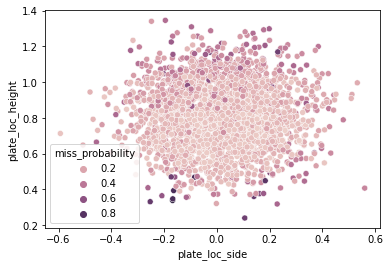

In [31]:
# Plotting the location of each pitch along with its swing and miss probability  
sns.scatterplot(x = test_df['plate_loc_side'],y = test_df['plate_loc_height'],hue = test_df['miss_probability'])

In [32]:
# This function reads the fastball data, and returns a scatterplot/hexbin plot of probabilities that a pitch will
# result in a swing and miss somewhere in/near the strikezone
def pitch_graph():
    
    # Import library
    import matplotlib.patches as patches
    
    # Data used is the same one we established earlier. Adjust the parameter if needed
    #data1 = pd.read_csv("kbo-fastballs-2021.csv")
     
    # Average speed and movement are used to test the model
    avg_speed = data1['rel_speed'].mean()
    avg_pl_s = data1['plate_loc_side'].mean()
    avg_pl_h = data1['plate_loc_height'].mean()
    avg_hb = data1['horz_break'].mean()
    avg_ivb = data1['induced_vert_break'].mean()
    
    # Top and Bottom of the strike zone converted from feet (top: 3.4, bot:1.75) to meters
    sz_top = 1.03632
    sz_bot = 0.5334 
    
    # X, Z coordinates for data plotting around the strikezone 
    plate_x = np.linspace(start = -0.45, stop = 0.45, num = 100)
    plate_z = np.linspace(start = sz_bot-0.05, stop = sz_top+0.05, num = 100)
    
    # Getting the cartesian product of the two arrays 
    plate_product = np.transpose([np.tile(plate_x, len(plate_z)), np.repeat(plate_z, len(plate_x))])
    
    # Forming the dataframe 
    df = pd.DataFrame(data = plate_product, columns = ['plate_x','plate_z'])
    df['release_speed']= avg_speed
    df['plate_loc_side']= avg_pl_s
    df['plate_loc_height']= avg_pl_h
    df['horz_break']= avg_hb 
    df['induced_vert_break']= avg_ivb
    df['strikes']= 9
    df['balls']= 9
 
    # Calculating the probability of a miss
    swing_prob = clf.predict_proba(df.values)
    sp = pd.DataFrame(data = swing_prob, columns = ['hit_prob','miss_prob'])
    df['miss_prob'] = sp['miss_prob']
    
    # Creating the strikezone, converting elements from feet to meters
    strikezone = patches.Rectangle(((-(17/39)/2),sz_bot), width= 17/39, height = (sz_top-sz_bot), fill=False)
    
    # Plot the graph
    fig, ax = plt.subplots()
    graph = ax.hexbin(df['plate_x'],df['plate_z'], C =df['miss_prob'], 
              gridsize=(7), vmax = 1,vmin =0, cmap = 'Blues')    
    
    title = 'KBO Fastball swing and miss probability'
    
    ax.add_patch(strikezone)
    ax.axis('equal')
    ax.set_title(title)
    
    cbar = fig.colorbar(graph)
    cbar.set_label('Swing and Miss probability')
    
    return graph

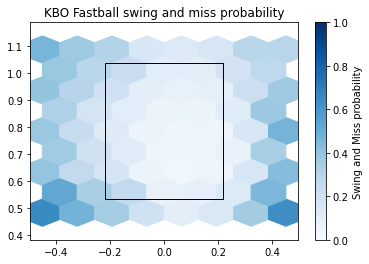

In [33]:
pitch_graph()

In [34]:
# This function is a more customizeable version of the previous function in which it takes as input the situation
# of the at-bat (balls, strikes, and outs), and what hand the pitcher throws with.
# Like the previous function. This function also returns a hexbin plot of the probabilities that a fastball will 
# result in a swing and miss
# balls: How many balls in the count
# strikes: How many strikes in the count
# outs: How many outs are taken prior to this at-bat
# throws: The throwing hand of the pitcher

def pitch_graph_C(balls, strikes, outs, throws):
    
    # Import library
    import matplotlib.patches as patches
    
    # Read data (Data used is the same as previously established) Adjust if needed
    pitch = pd.read_csv("kbo-fastballs-2021.csv")
    
    # Ensure that letter input is capitalized
    throws = throws.upper()
    
    # ERROR HANDLING
    if(balls > 3 | balls < 0):
        return "# of balls in count is invalid, 0,1,2,3 accepted"
    elif(strikes > 2 | strikes < 0):
        return "# of strikes in count is invalid, 0,1,2 accepted"
    elif(outs > 2 | outs < 0):
        return "# of outs is invalid, 0,1,2 accepted"
    elif(throws != 'L'):
        if(throws != 'R'):
            return "Pitcher throws either Left handed or Right handed, L or R accepted"
    ################
    
    # Clean data based on what was specified
    data1 = pitch.loc[(pitch['balls'] == balls) & (pitch['strikes'] == strikes) & (pitch['outs'] == outs) &
                      (pitch['pitcher_throws'] == throws)]
    
    # Average speed and movement are used to test the model
    avg_speed = data1['rel_speed'].mean()
    avg_pl_s = data1['plate_loc_side'].mean()
    avg_pl_h = data1['plate_loc_height'].mean()
    avg_hb = data1['horz_break'].mean()
    avg_ivb = data1['induced_vert_break'].mean()
    
    # Top and Bottom of the strike zone converted from feet (top: 3.4, bot:1.75) to meters
    sz_top = 1.03632 
    sz_bot = 0.5334 
    
    # X, Z coordinates for data plotting around the strikezone 
    plate_x = np.linspace(start = -0.45, stop = 0.45, num = 100)
    plate_z = np.linspace(start = sz_bot-0.05, stop = sz_top+0.05, num = 100)
    
    # Getting the cartesian product of the two arrays 
    plate_product = np.transpose([np.tile(plate_x, len(plate_z)), np.repeat(plate_z, len(plate_x))])
    
    # Forming the dataframe 
    df = pd.DataFrame(data = plate_product, columns = ['plate_x','plate_z'])
    
    df['release_speed']= avg_speed
    df['plate_loc_side']= avg_pl_s
    df['plate_loc_height']= avg_pl_h
    df['horz_break']= avg_hb
    df['induced_vert_break']= avg_ivb
    df['strikes']= strikes
    df['balls']= balls

    # Calculating the probability of a miss
    miss_prob = clf.predict_proba(df.values)
    sp = pd.DataFrame(data = miss_prob, columns = ['hit_prob','miss_prob'])
    df['miss_prob'] = sp['miss_prob']

    # Creating the strikezone, converting elements from feet to meters
    strikezone = patches.Rectangle(((-(17/39)/2),sz_bot), width= 17/39, height = (sz_top-sz_bot), fill=False)
    
    # Plot the graph
    fig, ax = plt.subplots()
    graph = ax.hexbin(df['plate_x'],df['plate_z'], C = df['miss_prob'], 
              gridsize=(7), vmax = 1,vmin =0, cmap = 'Reds')    
    
    title = ('Swing and Miss probability for ' + throws + 'HP with ' 
             + (str(balls)) + '-' + (str(strikes)) + ' count and ' + (str(outs)) + ' out(s)')
    
    ax.add_patch(strikezone)
    ax.axis('equal')
    ax.set_title(title)
    
    cbar = fig.colorbar(graph)
    cbar.set_label('Swing and Miss probability')
    
    return graph

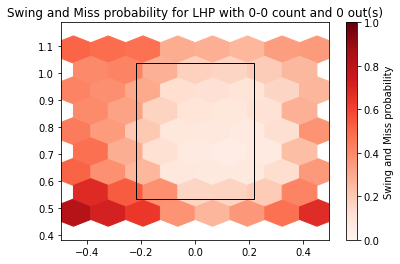

In [35]:
# LHP Fastball swing/miss on first pitch
pitch_graph_C(0,0,0,"L")

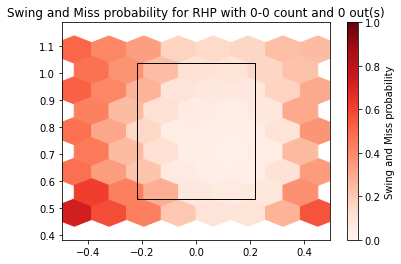

In [36]:
# RHP Fastball swing/miss on first pitch
pitch_graph_C(0,0,0,"R")

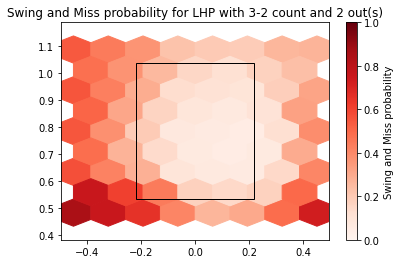

In [37]:
# LHP full count, 2 outs, swing/miss
pitch_graph_C(3,2,2,"L")

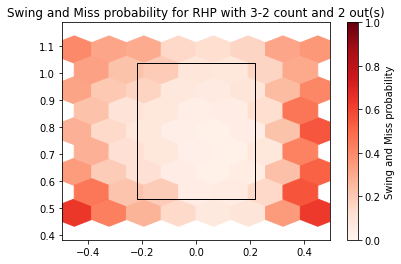

In [38]:
# RHP full count, 2 outs, swing/miss
pitch_graph_C(3,2,2,"R")